In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import random 
from math import atan2, degrees

In [ ]:
data = pd.read_parquet("wetransfer_test-parquet_2025-11-07_1308/train.parquet", engine="pyarrow")

In [ ]:
n_lags = 10          # number of previous points used for prediction

In [ ]:
# Train a model for each mmsi and segment
def train_segment(mmsi, segment, df_seg, n_lags=10):
    df_seg = df_seg.sort_values("Timestamp").reset_index(drop=True)
    df_seg = df_seg.dropna(subset=["Longitude", "Latitude", "SOG", "COG"])
    
    # Compute next-step targets 
    df_seg["lon_next"] = df_seg["Longitude"].shift(-1)
    df_seg["lat_next"] = df_seg["Latitude"].shift(-1)
    df_seg["sog_next"] = df_seg["SOG"].shift(-1)
    df_seg["cog_sin_next"] = np.sin(np.deg2rad(df_seg["COG"].shift(-1))) # convert the course to sin
    df_seg["cog_cos_next"] = np.cos(np.deg2rad(df_seg["COG"].shift(-1))) # convert the course to cos
 
    
    # Create lagged features (sliding window)
    for lag in range(1, n_lags+1):
        df_seg[f"lon_lag{lag}"] = df_seg["Longitude"].shift(lag)
        df_seg[f"lat_lag{lag}"] = df_seg["Latitude"].shift(lag)
        df_seg[f"sog_lag{lag}"] = df_seg["SOG"].shift(lag)
        df_seg[f"cog_sin_lag{lag}"] = np.sin(np.deg2rad(df_seg["COG"].shift(lag)))
        df_seg[f"cog_cos_lag{lag}"] = np.cos(np.deg2rad(df_seg["COG"].shift(lag)))
    
    df_seg = df_seg.dropna().reset_index(drop=True)
    if len(df_seg) < n_lags + 2:
        return (mmsi, segment, None)  # too short for lagged features
    
    # Define features and targets
    feature_cols = [c for c in df_seg.columns if "lag" in c]
    target_cols = ["lon_next", "lat_next", "sog_next", "cog_sin_next", "cog_cos_next"]
    X = df_seg[feature_cols].values
    y = df_seg[target_cols].values
    
    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluation - RSME
    val_pred = model.predict(X_val_scaled)
    test_pred = model.predict(X_test_scaled)
    
    rmse_val = np.sqrt(mean_squared_error(y_val[:, :2], val_pred[:, :2]))  # only lon/lat
    rmse_test = np.sqrt(mean_squared_error(y_test[:, :2], test_pred[:, :2]))
    
    return {
        "MMSI": mmsi, 
        "Segment": segment,
        "model": model,
        "scaler": scaler,
        "df_seg": df_seg,
        "feature_cols": feature_cols,
        "target_cols": target_cols,
        "rmse_val": rmse_val,
        "rmse_test": rmse_test
    }

# Train all segments in parallel 
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(train_segment)(mmsi, segment, df, n_lags)
    for (mmsi, segment), df in tqdm(data.groupby(["MMSI", "Segment"]), desc="Training models")
)

Training models:   0%|          | 0/74609 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 2412 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 4812 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6296 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9024 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12824 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 17024 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 21624 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 26624 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 32024 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 37824 tasks 

In [7]:
models = {}
skipped_segments = []

for r in results:
    if r is None or "model" not in r:
        # If the segment was too short or returned None
        skipped_segments.append(r)
        continue
    key = (r["MMSI"], r["Segment"])
    models[key] = r


print(f"Trained {len(models)} models successfully.")
print(f"Skipped {len(skipped_segments)} segments (too short).")

Trained 72479 models successfully.
Skipped 2130 segments (too short).


#### Prediction on a segment

In [75]:
# Pick a random mssi and segment 
mmsi, segment = random.choice(list(models.keys()))
res = models[(mmsi, segment)]
print(f"Selected vessel: {mmsi} and segment {segment}")

Selected vessel: 219164000 and segment 80


In [76]:
res

{'MMSI': 219164000,
 'Segment': 80,
 'model': LinearRegression(),
 'scaler': StandardScaler(),
 'df_seg':               Timestamp   Latitude  Longitude       SOG    COG       MMSI  \
 0   2024-12-13 00:50:04  57.821702  10.261605  5.401662   97.1  219164000   
 1   2024-12-13 00:55:03  57.819770  10.288677  5.350218   98.1  219164000   
 2   2024-12-13 01:00:04  57.818160  10.315885  5.350218   95.2  219164000   
 3   2024-12-13 01:05:03  57.816760  10.342798  5.298773   95.1  219164000   
 4   2024-12-13 01:10:03  57.815288  10.369615  5.247329   96.4  219164000   
 ..                  ...        ...        ...       ...    ...        ...   
 558 2024-12-14 23:30:01  57.902552   8.771423  4.629996  265.2  219164000   
 559 2024-12-14 23:35:11  57.902333   8.746782  4.732885  269.4  219164000   
 560 2024-12-14 23:40:11  57.902417   8.722597  4.887218  270.2  219164000   
 561 2024-12-14 23:45:22  57.902538   8.696740  4.887218  271.0  219164000   
 562 2024-12-14 23:50:12  57.902673  

In [77]:
# Get the data from the (mmsi and segment)
model = res["model"]
scaler = res["scaler"]
df_seg = res["df_seg"]
feature_cols = res["feature_cols"]

# Start from last window
last_window = df_seg[feature_cols].iloc[-1].values.reshape(1, -1)
last_window_scaled = scaler.transform(last_window)

# Last absolute position
last_lon = df_seg["Longitude"].iloc[-1]
last_lat = df_seg["Latitude"].iloc[-1]
last_sog = df_seg["SOG"].iloc[-1]
last_cog_sin = np.sin(np.deg2rad(df_seg["COG"].iloc[-1]))
last_cog_cos = np.cos(np.deg2rad(df_seg["COG"].iloc[-1]))

predicted_positions = []
# Start with last n_lags timesteps
window_values = df_seg[feature_cols].iloc[-1].values.copy()  # raw absolute positions + SOG/COG

steps_ahead = 7     # number of steps to predict ahead

for _ in range(steps_ahead):
    current_input = scaler.transform(window_values.reshape(1, -1))
    pred = model.predict(current_input)[0]
    
    lon_pred, lat_pred, sog_pred, cog_sin_pred, cog_cos_pred = pred
    predicted_positions.append([lon_pred, lat_pred])
    
    # Update window_values for next step
    window_values = np.roll(window_values, -5)
    window_values[-5:] = [lon_pred, lat_pred, sog_pred, cog_sin_pred, cog_cos_pred]

predicted_positions = np.array(predicted_positions)


In [78]:
predicted_positions

array([[ 8.68275269, 57.92440602],
       [ 8.72450049, 58.05583523],
       [ 8.83982441, 57.88144345],
       [ 8.64995514, 57.75663693],
       [ 8.66861957, 58.03536238],
       [ 9.05677399, 58.00983045],
       [ 8.64893409, 57.65891984]])

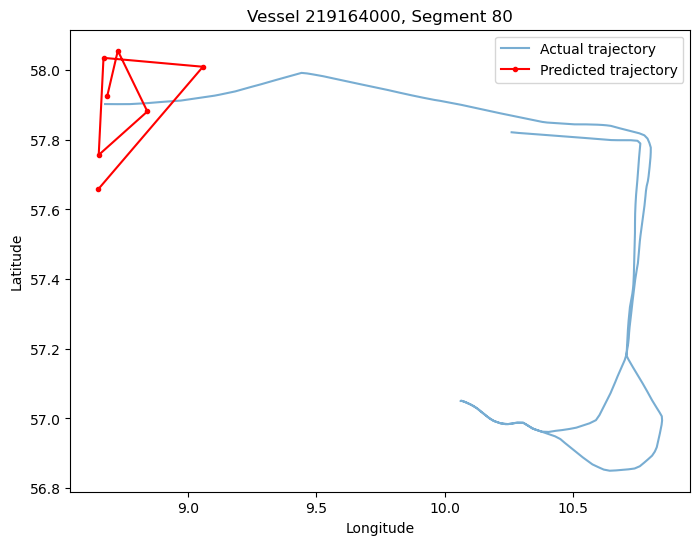

In [79]:
# --- Plot actual vs predicted trajectory ---
plt.figure(figsize=(8,6))
plt.plot(df_seg["Longitude"], df_seg["Latitude"], label="Actual trajectory", alpha=0.6)
plt.plot(predicted_positions[:,0], predicted_positions[:,1], "r.-", label="Predicted trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Vessel {mmsi}, Segment {segment}")
plt.legend()
plt.show()

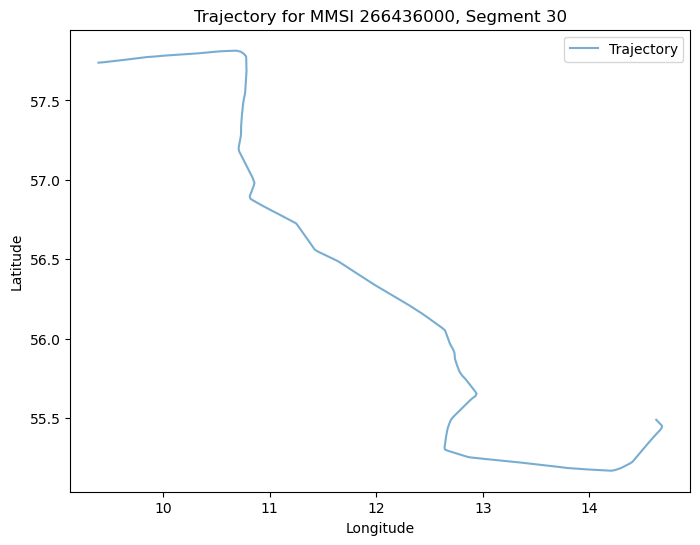

In [35]:
filtered_df = data[(data['MMSI'] == mmsi) & (data['Segment'] == segment)]
plt.figure(figsize=(8,6))
plt.plot(filtered_df["Longitude"], filtered_df["Latitude"], label="Trajectory", alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Trajectory for MMSI {mmsi}, Segment {segment}")
plt.legend()
plt.show()